<a href="https://colab.research.google.com/github/gordicaleksa/get-started-with-JAX/blob/main/Tutorial_1_JAX_Zero2Hero_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Warming up with JAX

This notebook heavily relies on https://jax.readthedocs.io/en/latest/ + some additional code/modifications, comments/notes, etc.

It also has [an accompanying video](https://youtu.be/SstuvS-tVc0) which may help you better understand all of the details!

<a href="https://www.youtube.com/watch?v=SstuvS-tVc0" target="_blank"><img src="https://img.youtube.com/vi/SstuvS-tVc0/0.jpg" 
alt="JAX - from Zero to Hero!" width="480" align="left" height="360" border="10" /></a>

### JAX 101

* JAX ❤️ NumPy!
* JAX ❤️ AI accelerators!

In [3]:
# JAX's syntax is (for the most part) same as NumPy's!
# There is also a SciPy API support (jax.scipy)
import jax.numpy as jnp
import numpy as np

# Special transform functions (we'll understand what these are very soon!)
from jax import grad, jit, vmap, pmap

# JAX's low level API 
# (lax is just an anagram for XLA, not completely sure how they came up with name JAX)
from jax import lax

from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt

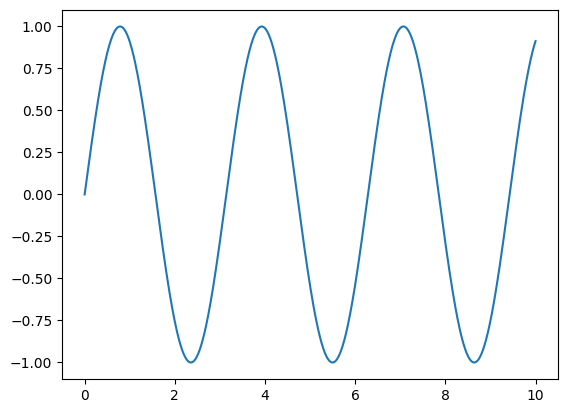

In [4]:
# Fact 1: JAX's syntax is remarkably similar to NumPy's 
x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


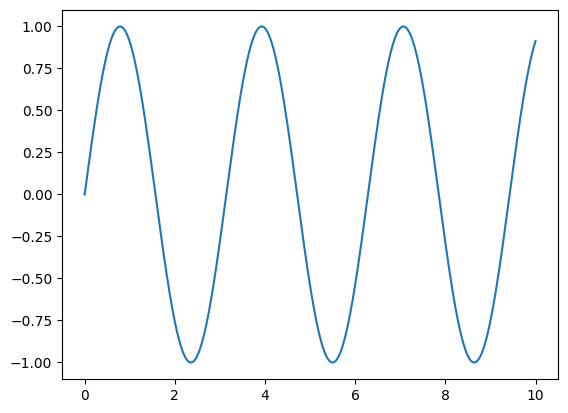

In [5]:
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

In [6]:
# Fact 2: JAX arrays are immutable! (embrace the functional programming paradigm <3)

size = 10
index = 0
value = 23

# In NumPy arrays are mutable
x = np.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [7]:
# In JAX we have to deal with immutable arrays
x = jnp.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]


TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [8]:
# Solution/workaround:
y = x.at[index].set(value)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [9]:
# Fact 3: JAX handles random numbers differently (for a good reason! we'll see later why)
seed = 0
key = random.PRNGKey(seed)

x = random.normal(key, (10, ))  # you need to explicitly pass the key i.e. PRNG state
print(type(x), x)  # notice the DeviceArray type - that leads us to the next cell!

<class 'jaxlib.xla_extension.ArrayImpl'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [10]:
# Fact 4: JAX is AI accelerator agnostic. Same code runs everywhere!

size = 3000

# Data is automagically pushed to the AI accelerator! (DeviceArray structure)
# No more need for ".to(device)" (PyTorch syntax)
x_jnp = random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)  # some diff in API exists!

%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()  # 1) on GPU - fast
%timeit np.dot(x_np, x_np.T)  # 2) on CPU - slow (NumPy only works with CPUs)
%timeit jnp.dot(x_np, x_np.T).block_until_ready()  # 3) on GPU with transfer overhead

x_np_device = device_put(x_np)  # push NumPy explicitly to GPU
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()  # same as 1)

# Note1: I'm using GPU as a synonym for AI accelerator. 
# In reality, especially in Colab, this can also be a TPU, etc.

# Note2: block_until_ready() -> asynchronous dispatch

80.4 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
55 ms ± 4.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
102 ms ± 8.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
98.8 ms ± 561 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## JAX transform functions

### `jit()` 101

* `jit` compiles your functions using XLA and caches them -> speeeeed 🚀

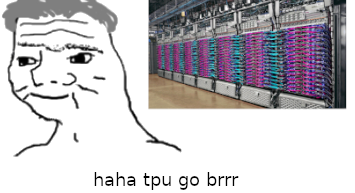

In [11]:
# Simple helper visualization function
def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y = fn(x)
    plt.plot(x, y); plt.show()

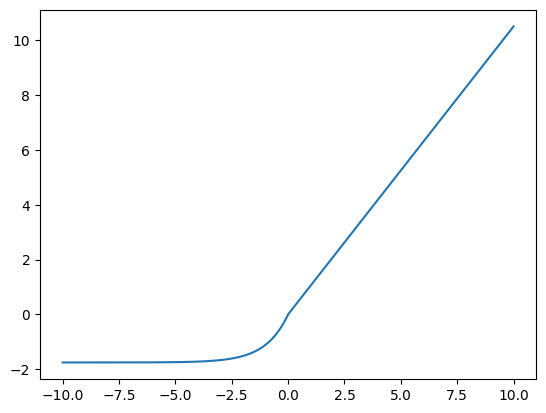

non-jit version:
591 µs ± 8.08 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
jit version:
193 µs ± 6.11 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
# Define a function
def selu(x, alpha=1.67, lmbda=1.05):  # note: SELU is an activation function
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jit(selu)  # let's jit it

# Visualize SELU (just for your understanding, it's always a good idea to visualize stuff)
visualize_fn(selu)

# Benchmark non-jit vs jit version
data = random.normal(key, (1000000,))

print('non-jit version:')
%timeit selu(data).block_until_ready()
print('jit version:')
%timeit selu_jit(data).block_until_ready()

# Note: we'll soon see how this works (hint: jaxpr, pure functions)

### `grad()` 101

Differentation can be:
* manual
* symbolic
* numeric
* automatic! ❤️

In [13]:
# First example (automatic diff)

def sum_logistic(x):  # or maybe a simpler example: sum of squares? (jnp.sum(x**2))
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x = jnp.arange(3.)
loss = sum_logistic  # rename it to give it some semantics

# By default grad calculates the derivative of a fn w.r.t. 1st parameter!
# Here we bundled inputs into a 1st param so it doesn't matter.
grad_loss = grad(loss)

print(grad_loss(x))

[0.25       0.19661197 0.10499357]


In [14]:
# Numeric diff (to double check that autodiff works correctly)

def finite_differences(f, x):
    eps = 1e-3
    # f(0+e, 1, 2) - f(0-e, 1, 2) / 2e
    return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)  # derivative definition
                                for v in jnp.eye(len(x))])

print(finite_differences(loss, x))

[0.24998187 0.1965761  0.10502338]


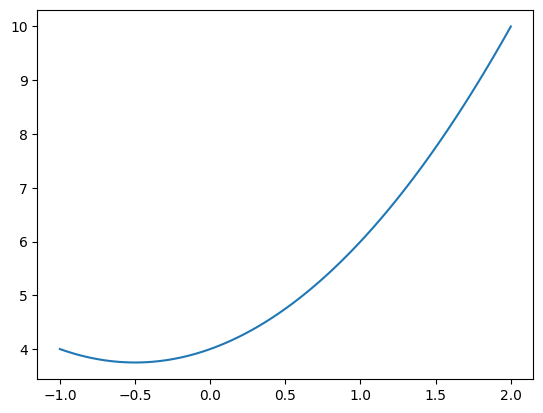

6.0 3.0 2.0 0.0


In [15]:
# Second example (automatic diff)

x = 1.  # example input

f = lambda x: x**2 + x + 4  # simple 2nd order polynomial fn
visualize_fn(f, l=-1, r=2, n=100)

dfdx = grad(f)  # 2*x + 1
d2fdx = grad(dfdx)  # 2
d3fdx = grad(d2fdx)  # 0

print(f(x), dfdx(x), d2fdx(x), d3fdx(x))

# Task: what if we had 2 inputs?

# Note1: Closer to math! 
# Note2: More powerful compared to .backward() (PyTorch syntax)

In [24]:
# JAX autodiff engine is very powerful ("advanced" example)

from jax import jacfwd, jacrev

f = lambda x, y: (x**2 + y**4 + 2*x * y**2 ) /  y**4 # simple paraboloid (google it...)

# df/dx = 2x
# df/dy = 2y
# J = [df/dx, df/dy]

# d2f/dx = 2
# d2f/dy = 2
# d2f/dxdy = 0
# d2f/dydx = 0
# H = [[d2f/dx, d2f/dxdy], [d2f/dydx, d2f/dy]]

def hessian(f):
    return jit(jacfwd(jacrev(f, argnums=(0, 1)), argnums =(0, 1)))

print(f'Jacobian = {jacrev(f, argnums=(0, 1))(1., 1.)}')
print(f'Full Hessian = {hessian(f)(1., 1.)}')

Jacobian = (Array(4., dtype=float32, weak_type=True), Array(-8., dtype=float32, weak_type=True))
Full Hessian = ((Array(2., dtype=float32, weak_type=True), Array(-12., dtype=float32, weak_type=True)), (Array(-12., dtype=float32, weak_type=True), Array(32., dtype=float32, weak_type=True)))


In [25]:
# JAX autodiff engine is very powerful ("advanced" example)

from jax import jacfwd, jacrev

f = lambda x, y: (x**2 + y**4 + 2*x * y**2 ) /  y**4 # simple paraboloid (google it...)

# df/dx = 2x
# df/dy = 2y
# J = [df/dx, df/dy]

# d2f/dx = 2
# d2f/dy = 2
# d2f/dxdy = 0
# d2f/dydx = 0
# H = [[d2f/dx, d2f/dxdy], [d2f/dydx, d2f/dy]]

def hessian(f):
    return jit(jacrev(jacfwd(f, argnums=(0, 1)), argnums =(0, 1)))

print(f'Jacobian = {jacrev(f, argnums=(0, 1))(1., 1.)}')
print(f'Full Hessian = {hessian(f)(1., 1.)}')

Jacobian = (Array(4., dtype=float32, weak_type=True), Array(-8., dtype=float32, weak_type=True))
Full Hessian = ((Array(2., dtype=float32, weak_type=True), Array(-12., dtype=float32, weak_type=True)), (Array(-12., dtype=float32, weak_type=True), Array(32., dtype=float32, weak_type=True)))


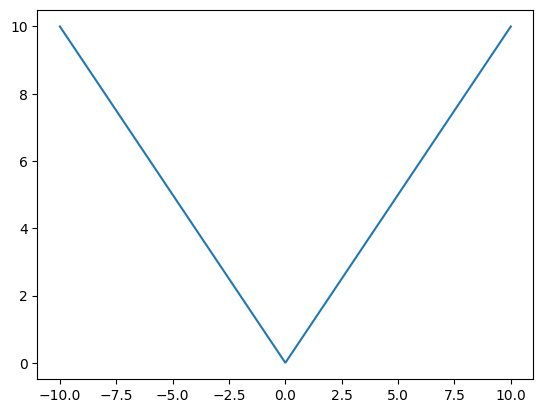

1 1
1.0


In [17]:
# Edge case |x|, how does JAX handle it?

f = lambda x: abs(x)
visualize_fn(f)

print(f(-1), f(1))
dfdx = grad(f)
print(dfdx(0.))  # play with numbers around 0 and see how JAX handles it

### `vmap()` 101

* Write your functions as if you were dealing with a single datapoint!

In [18]:
W = random.normal(key, (150, 100))  # e.g. weights of a linear NN layer
batched_x = random.normal(key, (10, 100))  # e.g. a batch of 10 flattened images

def apply_matrix(x):
    return jnp.dot(W, x)  # (150, 100) * (100, 1) -> (150, 1)

In [27]:
def naively_batched_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
781 µs ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [26]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T)  # (10, 100) * (100, 150) -> (10, 150)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
10.7 µs ± 24.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [28]:
@jit  # Note: we can arbitrarily compose JAX transforms! Here jit + vmap.
def vmap_batched_apply_matrix(batched_x):
    return vmap(apply_matrix)(batched_x)

# Task: modify apply_matrix to have 2 inputs and use in_axes arg

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
23.8 µs ± 797 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Going deeper 🌊

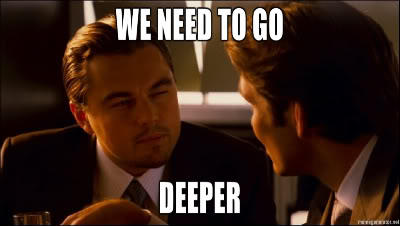

### JAX API structure

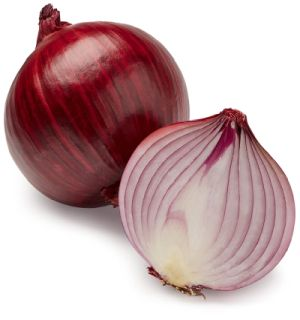

* NumPy <-> lax <-> XLA
* lax API is stricter and more powerful
* It's a Python wrapper around XLA 

In [ ]:
# Example 1: lax is stricter

print(jnp.add(1, 1.0))  # jax.numpy API implicitly promotes mixed types
print(lax.add(1, 1.0))  # jax.lax API requires explicit type promotion

In [ ]:
# Example 2: lax is more powerful (but as a tradeoff less user-friendly)

x = jnp.array([1, 2, 1])
y = jnp.ones(10)

# NumPy API
result1 = jnp.convolve(x, y)

# lax API
result2 = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float),  # note: explicit promotion
    y.reshape(1, 1, 10),
    window_strides=(1,),
    padding=[(len(y) - 1, len(y) - 1)])  # equivalent of padding='full' in NumPy

print(result1)
print(result2[0][0])
assert np.allclose(result1, result2[0][0], atol=1E-6)

# XLA: https://www.tensorflow.org/xla/operation_semantics#convwithgeneralpadding_convolution

### How does JIT actually work?

In [ ]:
# Why JIT? -> jitted functions are much faster.

def norm(X):
    X = X - X.mean(0)
    return X / X.std(0)

norm_compiled = jit(norm)

X = random.normal(key, (10000, 100), dtype=jnp.float32)

assert np.allclose(norm(X), norm_compiled(X), atol=1E-6)

%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

In [ ]:
# Example of a failure: array shapes must be static

def get_negatives(x):
    return x[x < 0]

x = random.normal(key, (10,), dtype=jnp.float32)
print(get_negatives(x))

In [ ]:
print(jit(get_negatives)(x))

In [ ]:
# So how does it work in the background? -> tracing on different levels of abstraction

@jit
def f(x, y):
    print("Running f():")
    print(f"  x = {x}")
    print(f"  y = {y}")
    result = jnp.dot(x + 1, y + 1)
    print(f"  result = {result}")
    return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
print(f(x, y))

x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
print('Second call:')
print(f(x2, y2))  # Oops! Side effects (like print) are not compiled...

# Note: any time we get the same shapes and types we just call the compiled fn!

In [ ]:
# Same function as above just without the print statements
def f(x, y):
    return jnp.dot(x + 1, y + 1)

print(make_jaxpr(f)(x, y))

{ lambda  ; a b.
  let c = add a 1.0
      d = add b 1.0
      e = dot_general[ dimension_numbers=(((1,), (0,)), ((), ()))
                       precision=None
                       preferred_element_type=None ] c d
  in (e,) }


In [ ]:
# 2nd example of a failure:

@jit
def f(x, neg):  # depends on the value - remember tracer cares about shapes and types!
    return -x if neg else x

f(1, True)

In [ ]:
# Workaround: the "static" arguments

from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
    print(x)
    return -x if neg else x

print(f(1, True))
print(f(2, True))
print(f(2, False))
print(f(23, False))

In [ ]:
# 3rd example of a failure:

# Task: add some print statements! (<expanding mind>)

@jit
def f(x):
    return x.reshape(jnp.array(x.shape).prod())

x = jnp.ones((2, 3))
f(x)

In [ ]:
# Workaround: using numpy instead of jax.numpy

@jit
def f(x):
    return x.reshape((np.prod(x.shape),))

f(x)

### Gotcha #1: Pure functions

* JAX is designed to work only on pure functions!

Pure function? Informal definition:
1. All the input data is passed through the function parameters, all the results are output through the function results.
2. A pure function will always return the same result if invoked with the same inputs.


In [ ]:
# Example 1

def impure_print_side_effect(x):
    print("Executing function")  # Violating #1
    return x

# The side-effects appear during the first run 
print ("First call: ", jit(impure_print_side_effect)(4.))

# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now invokes a cached compiled version of the function
print ("Second call: ", jit(impure_print_side_effect)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
print ("Third call, different type: ", jit(impure_print_side_effect)(jnp.array([5.])))

In [ ]:
# Example 2

g = 0.

def impure_uses_globals(x):
    return x + g  # Violating both #1 and #2

# JAX captures the value of the global during the first run
print ("First call: ", jit(impure_uses_globals)(4.))

# Let's update the global!
g = 10.

# Subsequent runs may silently use the cached value of the globals
print ("Second call: ", jit(impure_uses_globals)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print ("Third call, different type: ", jit(impure_uses_globals)(jnp.array([4.])))

In [ ]:
# Example 3: very important! Haiku/Flax are basically built upon this idea!

def pure_uses_internal_state(x):

    state = dict(even=0, odd=0)
    for i in range(10):
        state['even' if i % 2 == 0 else 'odd'] += x

    return state['even'] + state['odd']

print(jit(pure_uses_internal_state)(5.))

In [ ]:
# Example 4: iterators are a no no!

# lax.fori_loop; similarly for lax.scan, lax.cond, etc.
array = jnp.arange(10)
print(lax.fori_loop(0, 10, lambda i,x: x+array[i], 0))  # expected result 45

iterator = iter(range(10))
print(lax.fori_loop(0, 10, lambda i,x: x+next(iterator), 0))  # unexpected result 0

### Gotcha #2: In-Place Updates

In [ ]:
jax_array = jnp.zeros((3,3), dtype=jnp.float32)
updated_array = jax_array.at[1, :].set(1.0)

print("original array unchanged:\n", jax_array)
print("updated array:\n", updated_array)

# If this seems wasteful to you, congrats, you did some algorithms/data structures in your life. ;)
# The thing is - inside jit-compiled code, if the input value x of x.at[idx].set(y) 
# is not reused, the compiler will optimize the array update to occur in-place!

In [ ]:
# The expresiveness of NumPy is still there!

print("original array:")
jax_array = jnp.ones((5, 6))
print(jax_array)

print("new array post-addition:")
new_jax_array = jax_array.at[::2, 3:].add(7.)
print(new_jax_array)

### Gotcha #3: Out-of-Bounds Indexing

Due to JAX's accelerator agnostic approach JAX had to make a non-error behaviour for out of bounds indexing (similarly to how invalid fp arithmetic results in NaNs and not an exception).


In [ ]:
# NumPy behavior

try:
  np.arange(10)[11]
except Exception as e:
    print("Exception {}".format(e))

In [ ]:
# JAX behavior
# 1) updates at out-of-bounds indices are skipped
# 2) retrievals result in index being clamped
# in general there are currently some bugs so just consider the behavior undefined!

print(jnp.arange(10).at[11].add(23))  # example of 1)
print(jnp.arange(10)[11])  # example of 2)

### Gotcha #4: Non-array inputs

* This is added by design (performance reasons)

In [ ]:
# NumPy

print(np.sum([1, 2, 3]))

In [ ]:
# JAX

try:
    jnp.sum([1, 2, 3])
except TypeError as e:
    print(f"TypeError: {e}")

In [ ]:
# Why? jaxpr to the rescue!

def permissive_sum(x):
    return jnp.sum(jnp.array(x))

x = list(range(10))
print(make_jaxpr(permissive_sum)(x))

### Gotcha #5: random numbers

In [ ]:
# NumPy - PRNG is stateful!

# Let's sample calling the same function twice
print(np.random.random())
print(np.random.random())

np.random.seed(seed)

rng_state = np.random.get_state()
print(rng_state[2:])

_ = np.random.uniform()
rng_state = np.random.get_state()
print(rng_state[2:])

_ = np.random.uniform()
rng_state = np.random.get_state()
print(rng_state[2:])

# Mersenne Twister PRNG is known to have a number of problems (NumPy's imp of PRNG)

In [ ]:
# JAX's random functions can't modify PRNG's state!

key = random.PRNGKey(seed)
print(key)  # key defines the state (2 unsigned int32s)

# Let's again sample calling the same function twice
print(random.normal(key, shape=(1,)))
print(key)  # verify that the state hasn't changed

print(random.normal(key, shape=(1,)))  # oops - same results?
print(key)

In [ ]:
# Solution? -> Split every time you need a pseudorandom number.

print("old key", key)
key, subkey = random.split(key)
normal_pseudorandom = random.normal(subkey, shape=(1,))
print("    \---SPLIT --> new key   ", key)
print("             \--> new subkey", subkey, "--> normal", normal_pseudorandom)

# Note1: you can also split into more subkeys and not just 1
# Note2: key, subkey no difference it's only a convention

In [ ]:
# Why this design? 
# Well...think...with current design can the code be:
# 1) reproducible?
# 2) parallelizable?
# 3) vectorisable?

np.random.seed(seed)

def bar(): return np.random.uniform()
def baz(): return np.random.uniform()

# e.g. bar=0.3 baz=0.4 [0.3 + 2*0.4] [0.4 + 2*0.3] -> not reproducible in parallel envs!
def foo(): return bar() + 2 * baz()

print(foo())

# What if we want to parallelize this code? NumPy assumes too much. 2) is violated.

In [ ]:
# NumPy
np.random.seed(seed)
print("individually:", np.stack([np.random.uniform() for _ in range(3)]))

np.random.seed(seed)
print("all at once: ", np.random.uniform(size=3))

# JAX
key = random.PRNGKey(seed)
subkeys = random.split(key, 3)
sequence = np.stack([random.normal(subkey) for subkey in subkeys])
print("individually:", sequence)

key = random.PRNGKey(seed)
print("all at once: ", random.normal(key, shape=(3,)))

# NumPy violates 3)

### Gotcha #6: Control Flow

In [ ]:
# Python control flow + grad() -> everything is ok
def f(x):
    if x < 3:
        return 3. * x ** 2
    else:
        return -4 * x

x = np.linspace(-10, 10, 1000)
y = [f(el) for el in x]
plt.plot(x, y); plt.show()

print(grad(f)(2.))  # ok!
print(grad(f)(4.))  # ok!

In [ ]:
# Python control flow + jit() -> problems in paradise.

# "The tradeoff is that with higher levels of abstraction we gain a more general view
# of the Python code (and thus save on re-compilations), 
# but we require more constraints on the Python code to complete the trace."

# Example 1: conditioning on value (same function as in the above cell)
# Solution (recall: we already have seen this)
f_jit = jit(f, static_argnums=(0,))
x = 2.

print(make_jaxpr(f_jit, static_argnums=(0,))(x))
print(f_jit(x))

In [ ]:
# Example 2: range depends on value again

def f(x, n):
    y = 0.
    for i in range(n):
        y = y + x[i]
    return y

f_jit = jit(f, static_argnums=(1,))
x = (jnp.array([2., 3., 4.]), 15)

print(make_jaxpr(f_jit, static_argnums=(1,))(*x))  # notice how for loop gets unrolled
print(f_jit(*x))

# Note: there is a catch - static args should not change a lot!

In [ ]:
# Even "better" (it's less readable) solution is to use low level API
def f_fori(x, n):
    body_fun = lambda i,val: val+x[i]
    return lax.fori_loop(0, n, body_fun, 0.)

f_fori_jit = jit(f_fori)

print(make_jaxpr(f_fori_jit)(*x))
print(f_fori_jit(*x))

In [ ]:
# Example 3: this is not problematic (it'll only cache a single branch)

def log2_if_rank_2(x):
    if x.ndim == 2:
        ln_x = jnp.log(x)
        ln_2 = jnp.log(2.0)
        return ln_x / ln_2
    else:
        return x

print(make_jaxpr(log2_if_rank_2)(jnp.array([1, 2, 3])))

### Gotcha #7: NaNs

In [ ]:
jnp.divide(0., 0.)  # the default non-error behavior will simply return a NaN (as usually)

# If you want to debug where the NaNs are coming from, there are multiple ways
# to do that, here is one:
from jax.config import config
config.update("jax_debug_nans", True)

In [ ]:
# JAX enforces single precision! There are simple ways around it though.

x = random.uniform(key, (1000,), dtype=jnp.float64)
print(x.dtype)

Final conclusions, TL;DR:
* Excellent for researchers (very powerful, device agnostic code, etc.)
* Definitely way too complicated for beginners (functional paradigm, optimization details, etc.) compared to PyTorch

In the next video we'll go mid to high levels of abstraction introducing concepts such as PyTree, handling state (as that's a natural way to handle NNs) in a functional paradigm, etc.

### Connect with me ❤️

Last but not least I regularly post AI-related stuff (paper summaries, AI news,etc.) on my Twitter/LinkedIn. We also have an ever increasing Discord community (1100+ members at the time of writing this). If you care about any of these I encourage you to connect! 

Social: <br/>
💼 LinkedIn - https://www.linkedin.com/in/aleksagordic/ <br/>
🐦 Twitter - https://twitter.com/gordic_aleksa <br/>
👨‍👩‍👧‍👦 Discord - https://discord.gg/peBrCpheKE <br/>
🙏 Patreon - https://www.patreon.com/theaiepiphany <br/>

Content: <br/>
📺 YouTube - https://www.youtube.com/c/TheAIEpiphany/ <br/>
📚 Medium - https://gordicaleksa.medium.com/ <br/>
💻 GitHub - https://github.com/gordicaleksa <br/>
📢 AI Newsletter - https://aiepiphany.substack.com/ <br/>